<a href="https://colab.research.google.com/github/marcinwolter/SummerStudent2022_autoencoder/blob/main/Autoencoder_Keras_DEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Modified version of:

https://github.com/Mboga/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb

In [1]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [2]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics

import matplotlib.pyplot as plt


In [3]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], activation='linear', kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [4]:
# Read data from Rafal
! wget https://ppss.ifj.edu.pl/~rafal/data_ND.npz --no-check-certificate
! wget https://ppss.ifj.edu.pl/~rafal/data_DD.npz --no-check-certificate
! wget https://ppss.ifj.edu.pl/~rafal/data_SD.npz --no-check-certificate
data_ND = np.load('data_ND.npz')
data_DD = np.load('data_DD.npz')
data_SD = np.load('data_SD.npz')

print(type(data_DD))
lst = data_DD.files
for item in lst:
  print(item)

x_train0 = np.concatenate([data_ND['train_X'],data_DD['train_X'],data_SD['train_X']])
y_train0 = np.concatenate([data_ND['train_Y'],data_DD['train_Y'],data_SD['train_Y']])

x_test0 = np.concatenate([data_ND['test_X'],data_DD['test_X'],data_SD['test_X']])
y_test0 = np.concatenate([data_ND['test_Y'],data_DD['test_Y'],data_SD['test_Y']])

--2022-07-28 15:25:36--  https://ppss.ifj.edu.pl/~rafal/data_ND.npz
Resolving ppss.ifj.edu.pl (ppss.ifj.edu.pl)... 192.86.14.59
Connecting to ppss.ifj.edu.pl (ppss.ifj.edu.pl)|192.86.14.59|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 9580131 (9.1M)
Saving to: ‘data_ND.npz.4’

data_ND.npz.4       100%[===================>]   9.14M  5.77MB/s    in 1.6s    

2022-07-28 15:25:40 (5.77 MB/s) - ‘data_ND.npz.4’ saved [9580131/9580131]

--2022-07-28 15:25:40--  https://ppss.ifj.edu.pl/~rafal/data_DD.npz
Resolving ppss.ifj.edu.pl (ppss.ifj.edu.pl)... 192.86.14.59
Connecting to ppss.ifj.edu.pl (ppss.ifj.edu.pl)|192.86.14.59|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3488687 (3.3M)
Saving to: ‘data_DD.npz.4’

data_DD.npz.4       100%[===================>]   3.33M  2.73MB/s    in 1.2s    

2022-07-28 15:25:42 (2.73 MB/s) - ‘data_DD.npz.4’

Normalize the number of inputs in each class

In [5]:
print(np.count_nonzero(y_train0 == 1))
print(np.count_nonzero(y_train0 == 2))
print(np.count_nonzero(y_train0 == 3))
print(np.count_nonzero(y_train0 == 4))






x_train = np.array(x_train0)
y_train = np.array(y_train0)

print(y_train.shape)
print(x_train.shape)


print(np.count_nonzero(y_test0 == 1))
print(np.count_nonzero(y_test0 == 2))
print(np.count_nonzero(y_test0 == 3))
print(np.count_nonzero(y_test0 == 4))





x_test = np.array(x_test0)
y_test = np.array(y_test0)

print(y_test.shape)
print(x_test.shape)

print(y_train.shape)
print(x_train.shape)



35000
35011
34989
35000
(140000,)
(140000, 28, 28)
5000
4984
5016
5000
(20000,)
(20000, 28, 28)
(140000,)
(140000, 28, 28)


In [6]:
# load mnist images
#(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:


# Blurring images
import scipy 
from scipy.ndimage import gaussian_filter

'''
sigma_1 =100 #y_ish
sigma_2 =10 #x_ish
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

x_train = gaussian_filter(x_train, sigma=[sigma_1, sigma_2], order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
x_test = gaussian_filter(x_test, sigma=[sigma_1, sigma_2], order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)

'''
for i in range(len(x_train)):
   x_train[i] = scipy.ndimage.gaussian_filter(x_train[i], sigma=[2,2])

for i in range(len(x_test)):
   x_test[i] = scipy.ndimage.gaussian_filter(x_test[i], sigma=[2,2])


'\nfor i in range(len(x_train)):\n   x_train[i] = scipy.ndimage.gaussian_filter(x_train[i], sigma=[2,2])\n\nfor i in range(len(x_test)):\n   x_test[i] = scipy.ndimage.gaussian_filter(x_test[i], sigma=[2,2])\n'

In [8]:



x_train = x_train.reshape((x_train.shape[0], -1))
x_train = np.divide(x_train, 255.)
x_test = x_test.reshape((x_test.shape[0], -1))
x_test = np.divide(x_test, 255.)

In [9]:
n_clusters = len(np.unique(y_train))
print("n_clusters = ",n_clusters)
print("x_train shape: ",x_train.shape)
print("x_test shape: ",x_test.shape)

y_train = y_train
y_test = y_test
print(y_train)

n_clusters =  4
x_train shape:  (140000, 784)
x_test shape:  (20000, 784)
[1 1 1 ... 2 2 2]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


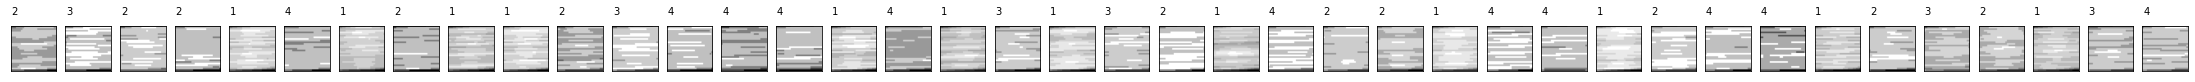

In [10]:

n = 40
plt.figure(figsize=(40, 8))
for i in range(n):
    # Display original
    k=np.random.randint(len(x_train))
    ax = plt.subplot(2, n+1, i+1)
    plt.imshow(x_train[k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    # label the image with the target value
    ax = plt.subplot(2, n+1, i+1)
    ax.text(0, -7, str(y_train[k]))
plt.show()

## Base line K-Means clustering accuracy

In [11]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20).fit(x_train)
y_pred_kmeans = kmeans.predict(x_test)

In [12]:
sklearn.metrics.rand_score(y_test, y_pred_kmeans)

0.8330213460673034

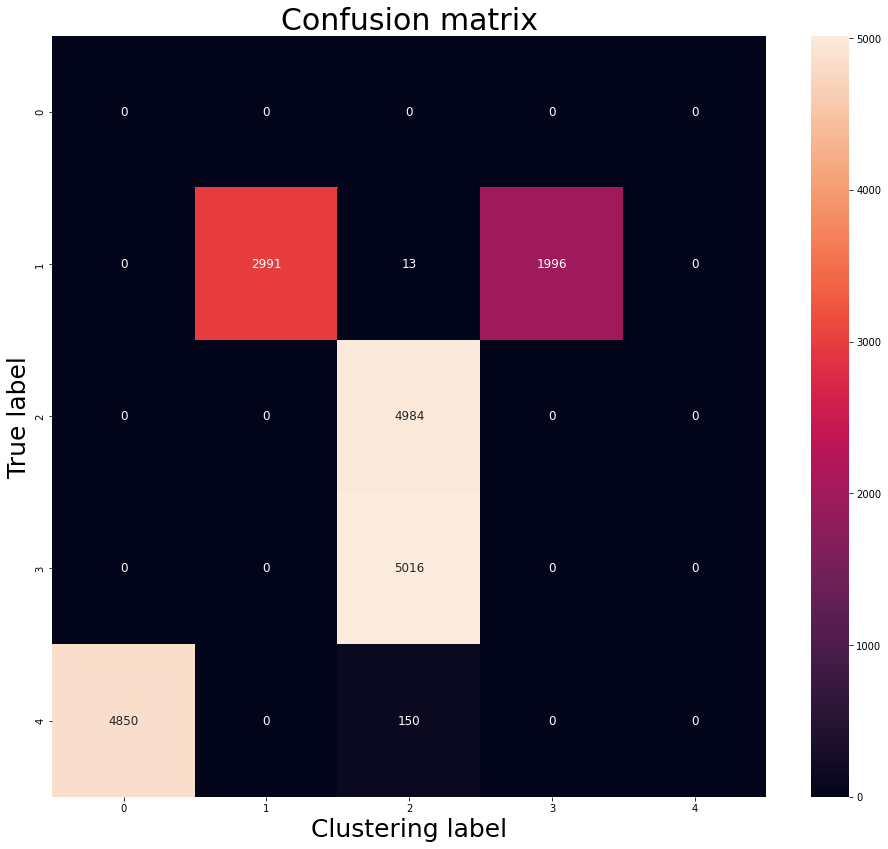

In [13]:
# Plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns


confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred_kmeans)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Hyper-params

In [14]:
dims = [x_train.shape[-1], 500, 500, 2000, 2]
#dims = [x_train.shape[-1], 400, 100, 29, 4]
#dims  = [x_train.shape[-1], 100, 100]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
#pretrain_optimizer = Adam()
pretrain_epochs = 300
batch_size = 256
save_dir = '.'

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [15]:
autoencoder, encoder = autoencoder(dims)#, init=init)

autoencoder.summary()
encoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 2)                 4002      
                                                                 
 decoder_3 (Dense)           (None, 2000)              6000      
                                                                 
 decoder_2 (Dense)           (None, 500)               1000500  

In [16]:
'''
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')
''' 

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)\nfrom IPython.display import Image\nImage(filename='autoencoder.png')\n"

In [17]:
'''
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 
'''

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(encoder, to_file='encoder.png', show_shapes=True)\nfrom IPython.display import Image\nImage(filename='encoder.png') \n"

## Pretrain auto-encoder

In [18]:
autoencoder.compile(optimizer=pretrain_optimizer,  loss="mean_squared_logarithmic_error") #loss='mse')
autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300
547/547 [==============================] - 3s 4ms/step - loss: 0.0024
Epoch 2/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 3/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 4/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 5/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 6/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 7/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 8/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 9/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 10/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 11/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 12/300
547/547 [==============================] - 2s 4ms/step - loss: 0.0021
Epoch 13/300


In [19]:
#autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [20]:
#autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

### ClusteringLayer

In [21]:
'''
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight((self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
'''

'\nclass ClusteringLayer(Layer):\n    """\n    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the\n    sample belonging to each cluster. The probability is calculated with student\'s t-distribution.\n\n    # Example\n    ```\n        model.add(ClusteringLayer(n_clusters=10))\n    ```\n    # Arguments\n        n_clusters: number of clusters.\n        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.\n        alpha: degrees of freedom parameter in Student\'s t-distribution. Default to 1.0.\n    # Input shape\n        2D tensor with shape: `(n_samples, n_features)`.\n    # Output shape\n        2D tensor with shape: `(n_samples, n_clusters)`.\n    """\n\n    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):\n        if \'input_shape\' not in kwargs and \'input_dim\' in kwargs:\n            kwargs[\'input_shape\'] = (kwargs.pop(\'input_dim\'),)\n

In [22]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20).fit(encoder.predict(x_train))
y_pred = kmeans.predict(encoder.predict(x_test))
print("rand_score = ",sklearn.metrics.rand_score(y_test,y_pred),"  clusters ",n_clusters)

rand_score =  0.8324033851692585   clusters  4


# Find confusion matrix

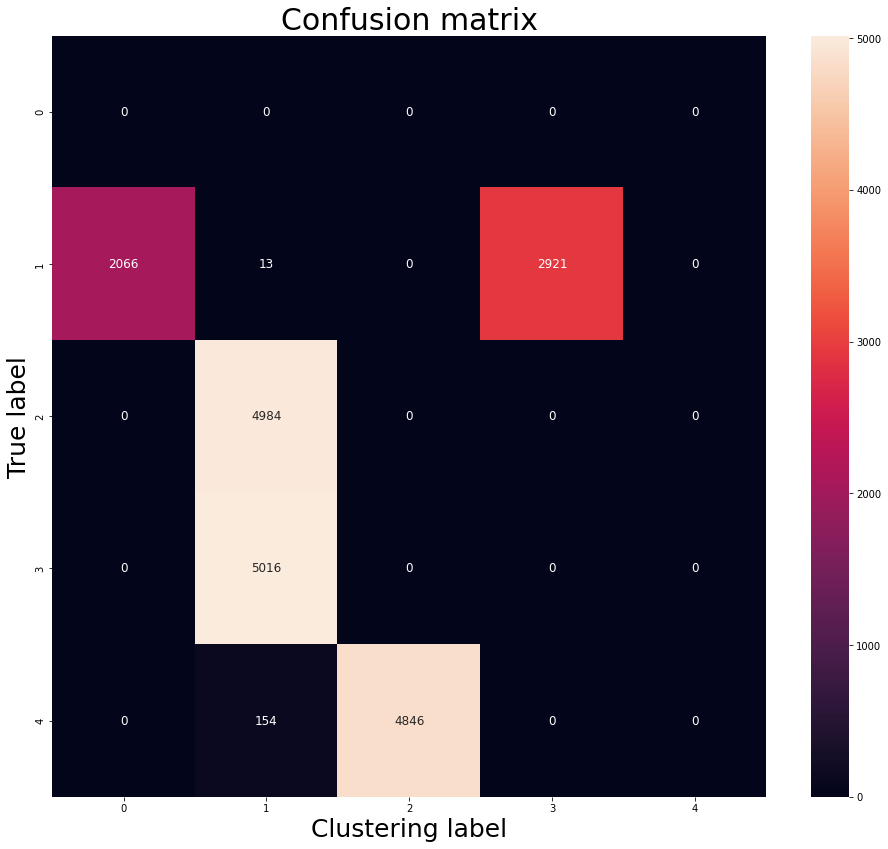

In [23]:
# Plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns


confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [24]:
# Preparation - find corresponding true and cluster labels

y_matched = np.empty_like(y_pred)

# For each cluster label...
for k in np.unique(y_pred):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((y_pred==k)*(y_test==t)) for t in np.unique(y_test)]
    y_matched[y_pred==k] = np.unique(y_test)[np.argmax(match_nums)]

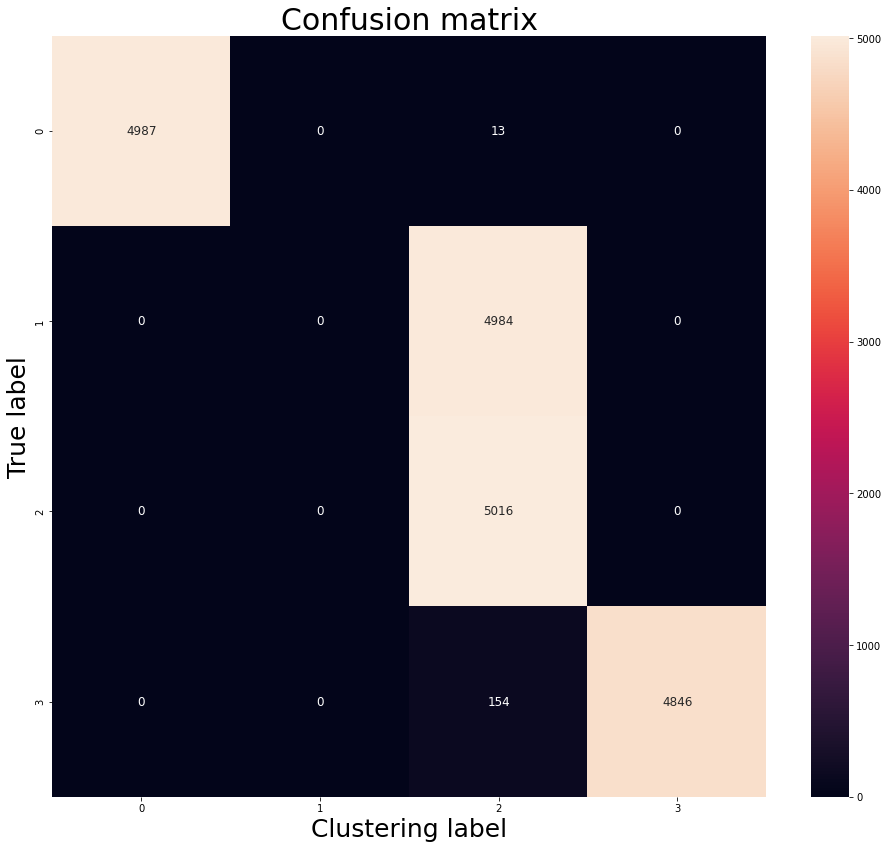

In [25]:
# Plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns


confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_matched)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

(20000, 2)


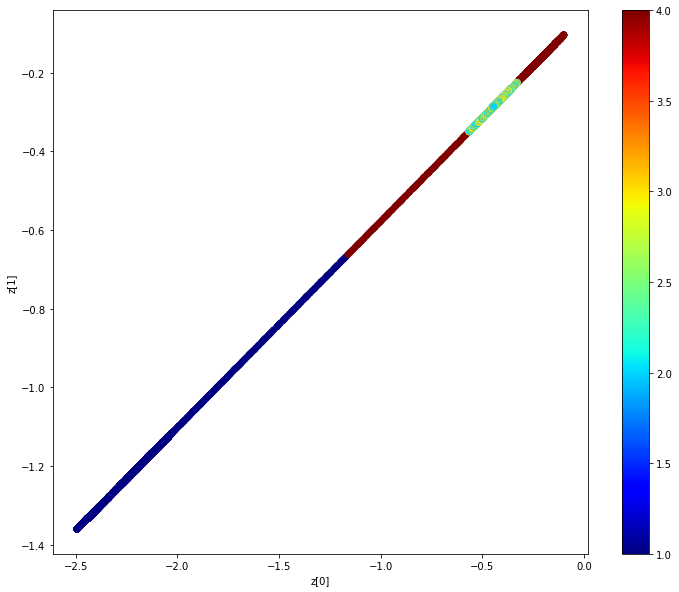

[1 1 1 ... 2 3 2]


In [26]:
import matplotlib.pyplot as plt 
#import itertools

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = vae.predict(data.reshape(len(data),784))
    print(z_mean.shape)

    #color_cycle= itertools.cycle(["orange","pink","blue","brown","red","grey","yellow","green","magenta","yellow"])
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='jet')
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()




plot_label_clusters(encoder, x_test, y_test)
print(y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


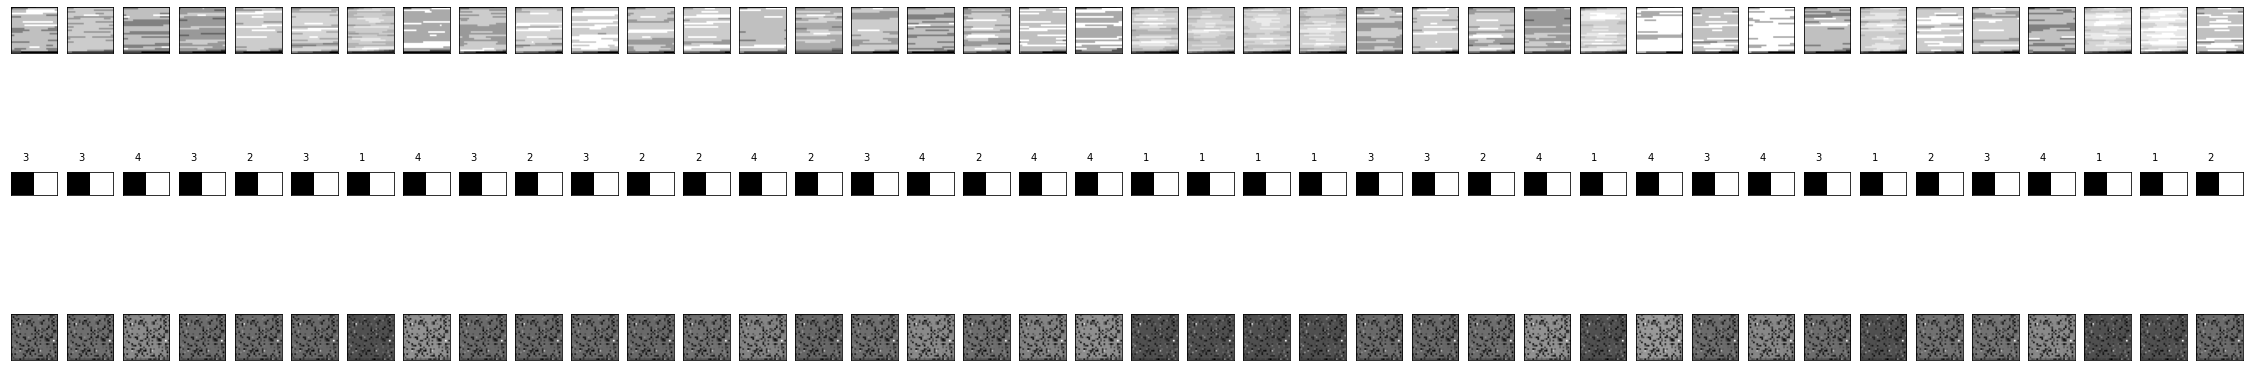

In [27]:
decoded_imgs = autoencoder.predict(x_train)
encoded_imgs = encoder.predict(x_train)

n = 40
plt.figure(figsize=(40, 8))
for i in range(1, n + 1):
    # Display original
    k=np.random.randint(len(x_train))
    ax = plt.subplot(3, n, i)
    plt.imshow(x_train[k].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    #Display bottle-neck
    ax = plt.subplot(3, n, i + n)
    plt.imshow(encoded_imgs[k].reshape(1,2))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display reconstruction
    ax = plt.subplot(3, n, i + n+n)
    plt.imshow(abs(decoded_imgs[k]).reshape(28, 28))
    #print(decoded_imgs[k])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    # label the image with the target value
    ax = plt.subplot(3, n, i+n)
    ax.text(0, -1, str(y_train[k]))

plt.show()


In [28]:
import sys
sys.exit()

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


In [ ]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

### Step 1: initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering
Compute p_i by first raising q_i to the second power and then normalizing by frequency per cluster:

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [ ]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

### Break down Accuracy metric

linear assignment- [Munkres' Assignment Algorithm](http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html)

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
w

In [ ]:
ind

In [ ]:
w.argmax(1)

## Experimental
Convolutional auto encoder.

In [ ]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np

### Convolutional auto encoder option 1
Use [`Conv2DTranspose`](https://keras.io/layers/convolutional/#conv2dtranspose) to reconstruct the image.

In [ ]:
def autoencoderConv2D_1(input_shape=(28, 28, 1), filters=[32, 64, 128, 10]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

### Convolutional auto encoder option 2
Use [`UpSampling2D`](https://keras.io/layers/convolutional/#upsampling2d) to reconstruct the image.

In [ ]:
def autoencoderConv2D_2(img_shape=(28, 28, 1)):
    """
    Conv2D auto-encoder model.
    Arguments:
        img_shape: e.g. (28, 28, 1) for MNIST
    return:
        (autoencoder, encoder), Model of autoencoder and model of encoder
    """
    input_img = Input(shape=img_shape)
    # Encoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(2, 2))(input_img)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
    shape_before_flattening = K.int_shape(x)
    # at this point the representation is (4, 4, 8) i.e. 128-dimensional
    x = Flatten()(x)
    encoded = Dense(10, activation='relu', name='encoded')(x)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(encoded)
    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape(shape_before_flattening[1:])(x)

    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


### Pick a convolutional autoencoder
`autoencoderConv2D_1` or `autoencoderConv2D_2`

In [ ]:
autoencoder, encoder = autoencoderConv2D_1()

In [ ]:
autoencoder.summary()

### Load MNIST data for convolutional input

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape(x.shape + (1,))
x = np.divide(x, 255.)

### Pretrain covolutional autoencoder

In [ ]:
pretrain_epochs = 100
batch_size = 256

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mse')

In [ ]:
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

In [ ]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

### Build clustering model with convolutional autoencoder

In [ ]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
model.compile(optimizer='adam', loss='kld')

### Step 1: initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

In [ ]:
y_pred_last = np.copy(y_pred)

In [ ]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

### Step 2: deep clustering

In [ ]:
loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])

In [ ]:
tol = 0.001 # tolerance threshold to stop training

### Start training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/conv_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Convolutional)
Multiple outputs model.

In [ ]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
                           outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 


### Initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/conv_b_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

## Model to train clustering and autoencoder at same time(Fully connected)
Multiple outputs model.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
n_clusters = len(np.unique(y))
x.shape

In [ ]:
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './results'

In [ ]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [ ]:
autoencoder, encoder = autoencoder(dims, init=init)
autoencoder.load_weights(save_dir+'/ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,
            outputs=[clustering_layer, autoencoder.output])

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

### Initialize cluster centers using k-means

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [ ]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

### Load the clustering model trained weights

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

### Final Evaluation

In [ ]:
# Eval.
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()